In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Week 5

In [3]:
def force(r1,r2,m1,m2):
    """
    Calculates the gravitational force on a mass m1 at position r1
    from a mass m2 at position r2
    
    Inputs
    r1        Position of the first mass
    r2        Position of the second mass
    m1        First mass
    m2        Second mass

    Returns
    f_on_m1   Force on m1 as a result of m2    
    """
    # Find r_12 and its magnitude
    r_12 = r2 - r1
    return (G * m1 * m2)/(np.sqrt(r_12[0]**2 + r_12[1]**2))**3 * r_12

In [4]:
G = 1
m1 = 1
m2 = 3e-6
m3 = 3.6e-8
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.0, 0.0025)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((-np.sqrt(G*m2/0.0025), 0)) + v2[0]


In [5]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) + force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) + force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



Text(0.5, 1.0, 'Velocity of planet 3 relative to planet 2')

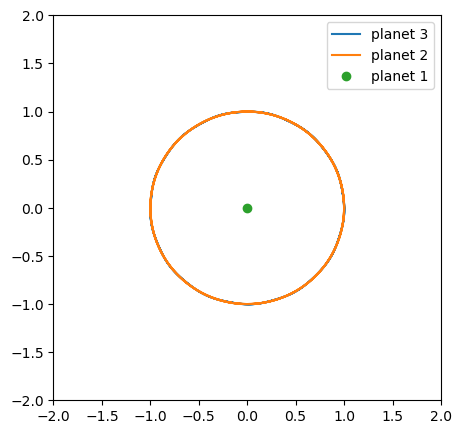

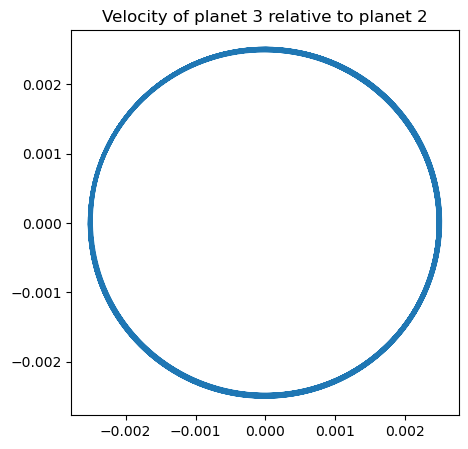

In [6]:
plt.figure(figsize=(5,5))
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(r2[:,0]-r3[:,0], r2[:,1]-r3[:,1], label='planet 2')
plt.title('Velocity of planet 3 relative to planet 2')

As is shown by the plot above, the velocity Verlet method gave rise to a good approximation of a 3-body system. With that said, the thickness of the line is indicative of a precision that may be improved by a different approach.

# Week 6/7

Now, we attempt to model the two-body orbit with a different integrator (fourth-order Runge Kutta).

In [7]:
def RK4_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,t) using fourth-order RK method.
    Inputs:
    fun  f(y,t)
    y0   Initial condition - assumed to be two-component
    dt   Step size
    N    Number of steps
    Returns: two arrays of length N+1 (x and v or equivalent)
    """
    # Storage for solution
    y = np.zeros((N+1,2,2))
    # Initial condition
    y[0] = y0
    t = 0
    for i in range(N):
        # RK4 formulae
        k1 = dt*fun(y[i],t,N)
        k2 = dt*fun(y[i]+0.5*k1,t+0.5*dt,N)
        k3 = dt*fun(y[i]+0.5*k2,t+0.5*dt,N)
        k4 = dt*fun(y[i]+k3,t+dt,N)
        y[i+1]=y[i]+(k1+2*k2+2*k3+k4)/6
        t += dt
    return y



In [8]:
def p2_RHS(y,t,n):
    m1 = 1.0

    pos = y[0]
    vel = y[1]

    r12 = np.array([0,0]) - pos
    r12_mag_cubed = np.linalg.norm(r12)**3
    
    dpos = vel
    dvel = G*m1*r12/r12_mag_cubed

    return np.array([dpos,dvel])

In [9]:
p2_initial_pos = np.array([1,0])
p2_initial_vel = np.array([0,np.sqrt(G*m1/1)])

N = 2000
dt = 0.01
p2_y_0 = np.array([p2_initial_pos, p2_initial_vel])

p2_results = RK4_solver(p2_RHS, p2_y_0, dt, N)

print(p2_results[0])

[[1. 0.]
 [0. 1.]]


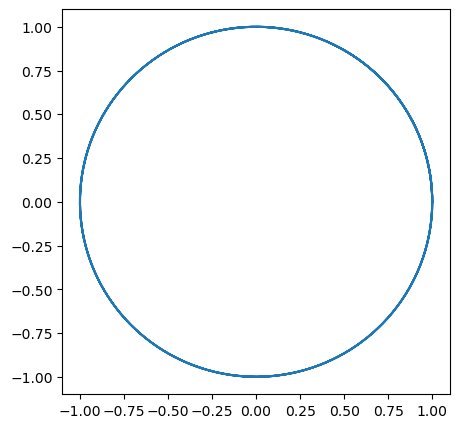

In [10]:
plt.figure(figsize=(5,5))
plt.plot(p2_results[:,0,0], p2_results[:,0,1])

# Week 8
## Simulating a Gravity Assist between a planet and a smaller object

Moving on from the mandatory part of the investigation, I will attempt to simulate a gravitational slingshot between an object and a planet in a circular orbit. Given my success with the velocity Verlet algorithm, the simulation will use this from this point onwards.
\
\
To achieve this, we begin by initialising the orbit of planet 2 around planet 1 like before. Planet 3 will be given an arbitrary position $(1.5, 1.5)$, and a trajectory to planet 2 will be calculated. Now, for the sake of simplicity, I will decide for the point of intersection to be around the point $(0,1)$ on the circular orbit of planet 2. Some kinematics will be used to determine the initial velocity planet 3. Most variables from earlier were used and adapted accordingly.

In [11]:
def collision_checker(r1, r2):
    '''
    A function to check to see if two objects have collided.
    The tolerance was chosen based on earlier calculations

    Inputs:
    r1, r2   Positions of the two bodies
    '''
    if np.linalg.norm(r1 - r2) <= 4e-5:
        print('Collision!')

In [12]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 3e-6
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(0.001-1.5), 
                  1/1.57*(1-1.5)))



Unlike the algorithm above, I have neglected the effect of planet 1 on planet 3. This was done so that I could examine the effects of planet 2 on planet 3 without having to consider any interactions with planet 1. I will consider adding the effect of the Sun once most aspects of the simulation work well.

In [13]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



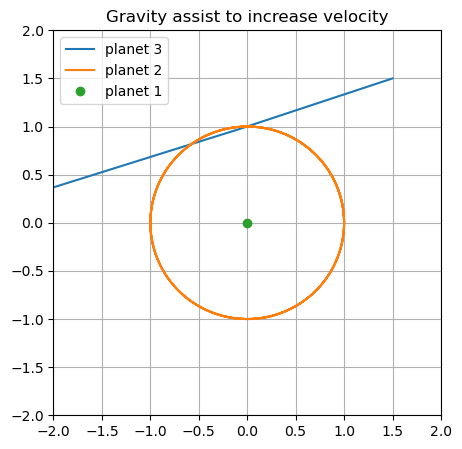

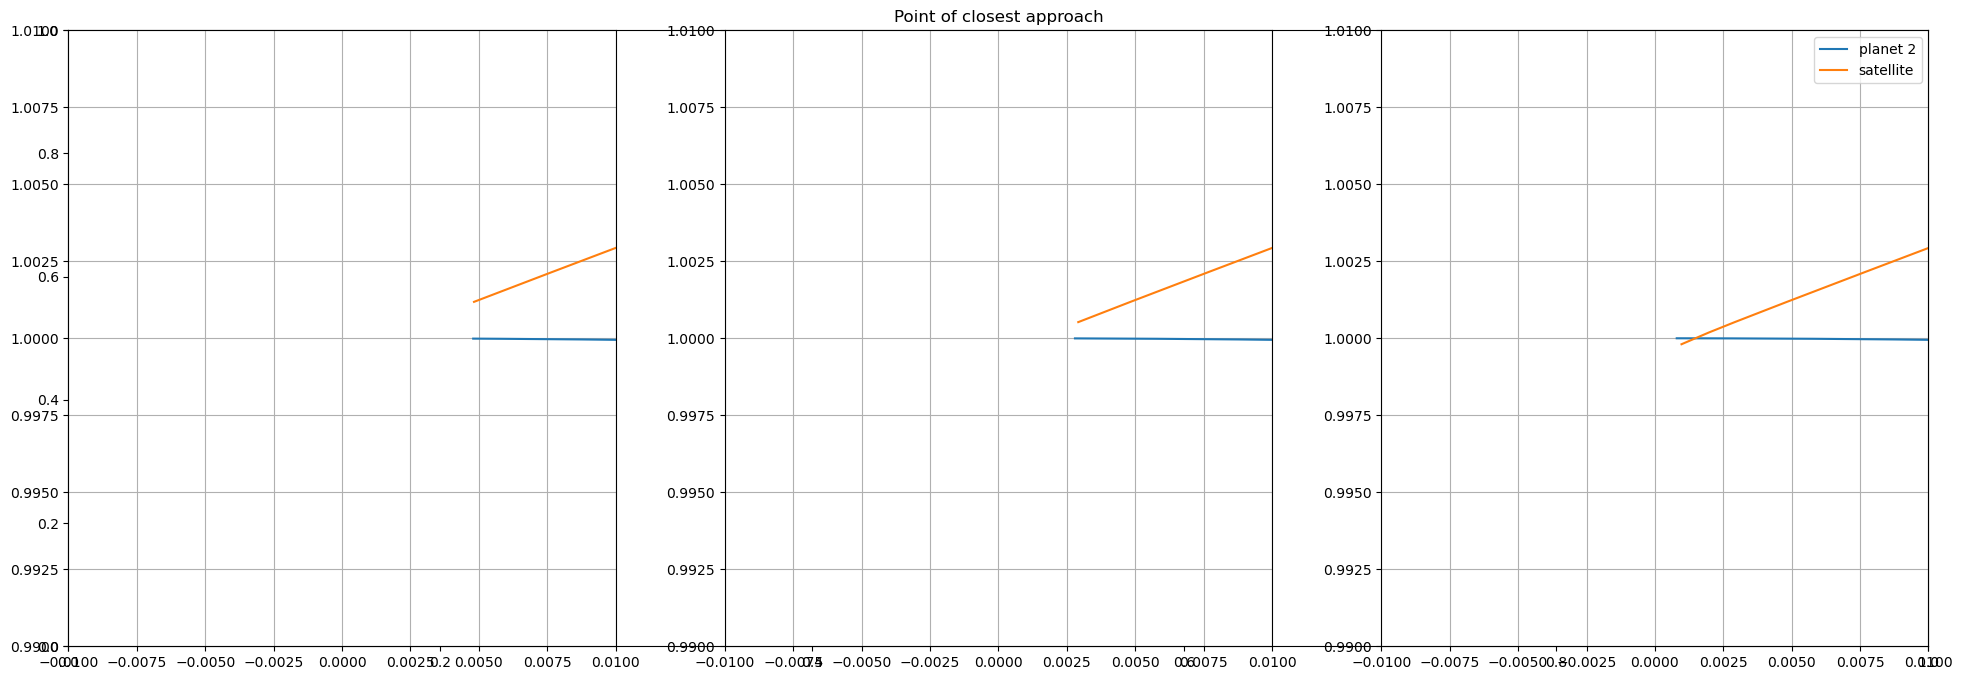

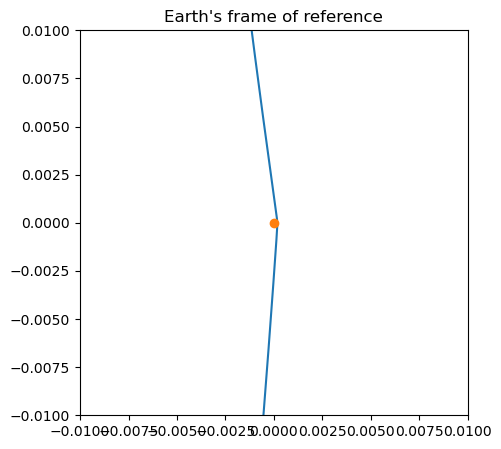

In [14]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist to increase velocity')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1565

fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 2*i,0], r2[:simend + 2*i,1], label='planet 2')
    ax.plot(r3[:simend + 2*i,0], r3[:simend + 2*i,1], label='satellite')
    ax.set_xlim(-0.01, 0.01)
    ax.set_ylim(0.99, 1.01)
    ax.grid()
plt.legend()
'''plt.figure(figsize=(5,5))
plt.title('Point of closest approach')
plt.plot(r2[:simend,0], r2[:simend,1], label='planet 2')
plt.plot(r3[:simend,0], r3[:simend,1], label='planet 2')
plt.xlim(-0.4, -0.3)
plt.ylim(0.9, 1.0)'''

plt.figure(figsize=(5,5))
plt.title('Earth\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)
plt.plot(0,0,'o')


In [15]:
'''# Rough work
print(r2[1570,1])
print(1/1.57*(r2[1570,0] - r3[0,0]))
print(1/1.57*(r2[1570,1] - r3[0,1]+0.08))

print(v3[0,1])
print(v3[-1,1])

print(np.linalg.norm(v3[0]))

print(max(np.linalg.norm(v3, axis=1)))

d = np.linalg.norm(r2-r3, axis=1)
closest_timestep = np.where(d == min(d))
print(closest_timestep)

print(np.min(np.linalg.norm(np.roll(r2,1)-r2, axis=1)))'''

print(r2[simend,0] - r2[simend-1,0])

print(r2[simend-1,0])

-0.0009999800530669616
0.006796297506463182


In [16]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 1.006490559508217
Final velocity of satellite: 1.0718588933449857
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522490997
Initial energy of both planets: 1.5e-06
Final energy of both planets: 1.499999556747332e-06
Difference in energies: 4.4325266804113477e-13
Point of closest approach: 0.000247332627498479


Text(0, 0.5, 'Velocity')

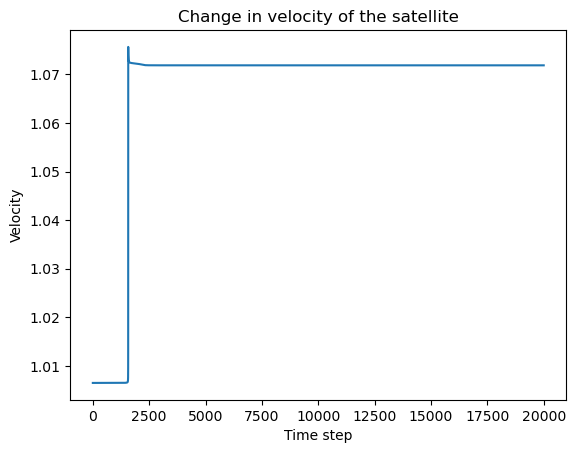

In [17]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

As can be seen from the above, there is an increase in the velocity of the satellite, and a slight decrease in the velocity of the planet. This alongside the calculations for initial and final energy also demonstrates that the conservation laws are obeyed for the most part, with a small error to the order of $10^{-10}$ that could be attributed to the limitations of the simulation. 
\
\
Now, I will attempt to do the same, but to set up the trajectory of the satellite so that it passes in front of instead of behind the planet. This, according to previous calculations, should decrease the velocity of the satellite and increase the velocity of the planet.

In [18]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 3e-6
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-0.0005-1.5), 
                  1/1.57*(1-1.5)))



In [19]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2, r3)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



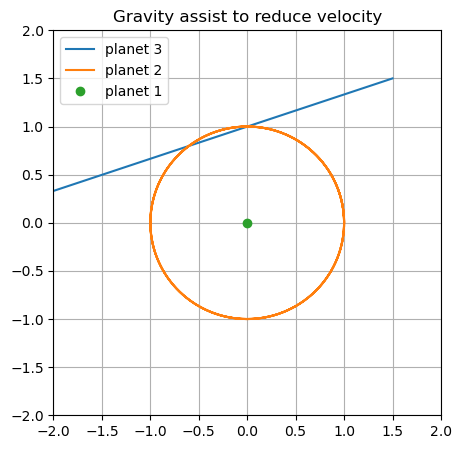

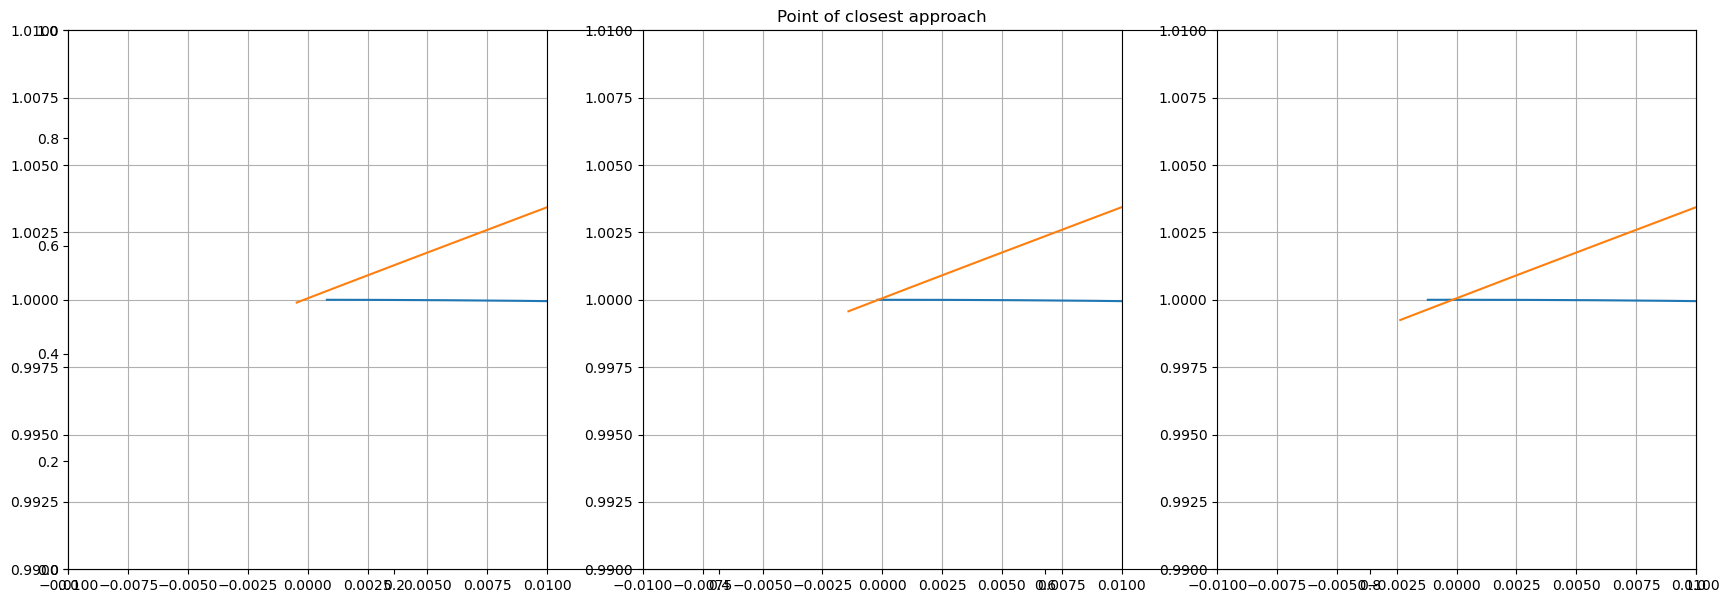

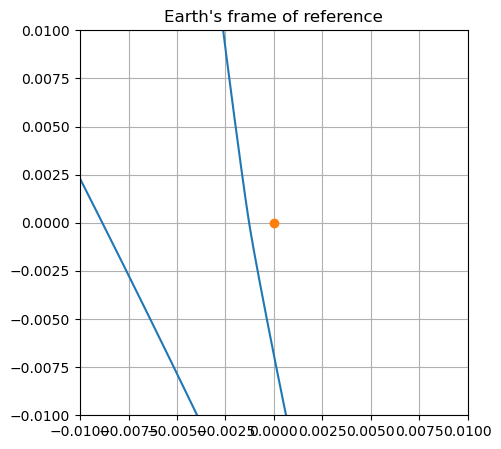

In [20]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist to reduce velocity')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1570

fig = plt.figure(figsize=(21,7))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(-0.01, 0.01)
    ax.set_ylim(0.99, 1.01)
    ax.grid()

plt.figure(figsize=(5,5))
plt.title('Earth\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)
plt.plot(0,0,'o')
plt.grid()

In [21]:
print(f'Initial velocity of planet 3: {np.linalg.norm(v3[0])}')
print(f'Final velocity of planet 3: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of planet 3: 1.0073969297048013
Final velocity of planet 3: 0.990690232880136
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522490997
Initial energy of both planets: 1.5e-06
Final energy of both planets: 1.499999556747332e-06
Difference in energies: 4.4325266804113477e-13
Point of closest approach: 0.001264688143906504


Text(0, 0.5, 'Velocity')

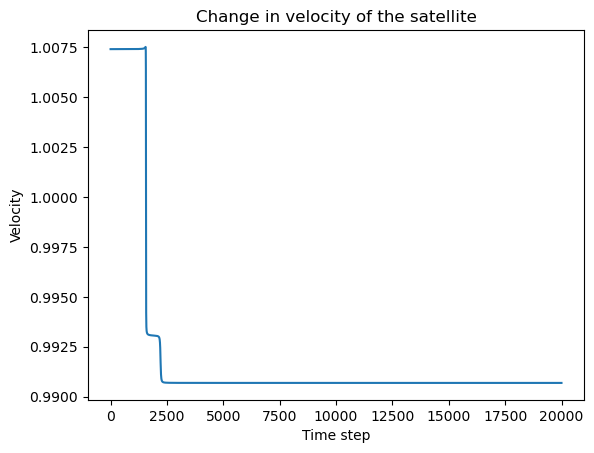

In [22]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

# Attempting a large slingshot with a larger mass
Continuing from here, we can set up a better-scaled model which can achieve some a more extreme velocity change. As opposed to considering a system comprised of Earth and the Sun, we will now explore one of Jupiter and the Sun. Upon constructing this two-body system, we will explore the motion of another satellite into the gravitational field of Jupiter. For the sake of ease, we will use the same initial conditions as previously to assist in performing calculations, as well as the same initial position of the satellite in the system.

In [23]:
def collision_checker(r1, r2):
    '''
    A function to check to see if two objects have collided.
    The tolerance was chosen based on earlier calculations

    Inputs:
    r1, r2   Positions of the two bodies
    '''
    if np.linalg.norm(r1 - r2) <= 5e-4:
        print('Collision!')

In [24]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.5, 1.5)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-1.5), 
                  1/1.57*(1-1.5)))

In [25]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



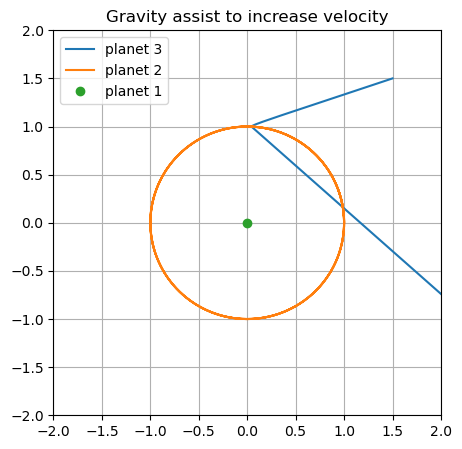

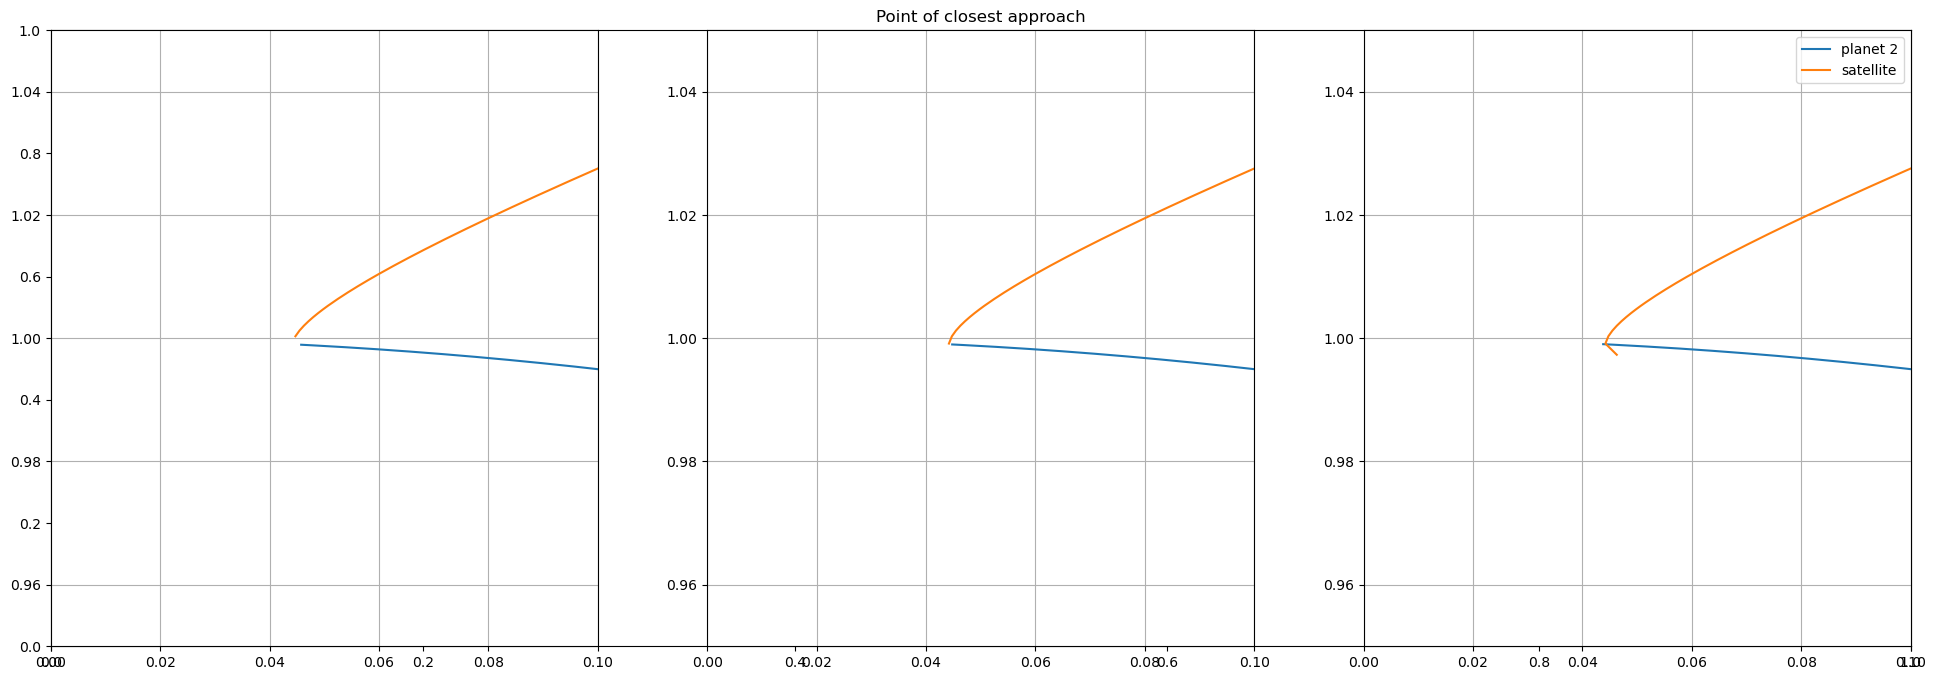

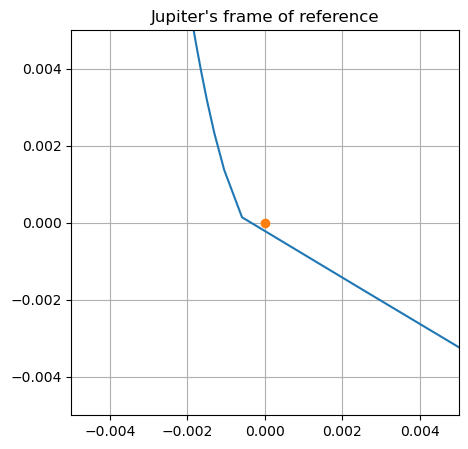

In [26]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist to increase velocity')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1525

fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

'''simend = 1530
plt.figure(figsize=(5,5))
plt.title('Point of closest approach')
plt.plot(r2[:simend,0], r2[:simend,1], label='planet 2')
plt.plot(r3[:simend,0], r3[:simend,1], label='planet 2')
plt.xlim(0,0.1)
plt.ylim(0.95, 1.05)
plt.grid()
'''


plt.figure(figsize=(5,5))
plt.title('Jupiter\'s frame of reference')
plt.plot(r3[1520:1540,0]-r2[1520:1540,0], r3[1520:1540,1]-r2[1520:1540,1])
plt.xlim(-0.005, 0.005)
plt.ylim(-0.005, 0.005)
plt.plot(0,0,'o')
plt.grid()


In [27]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 1.0070947962319678
Final velocity of satellite: 2.592455377016387
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.000609534962930454


Text(0, 0.5, 'Velocity')

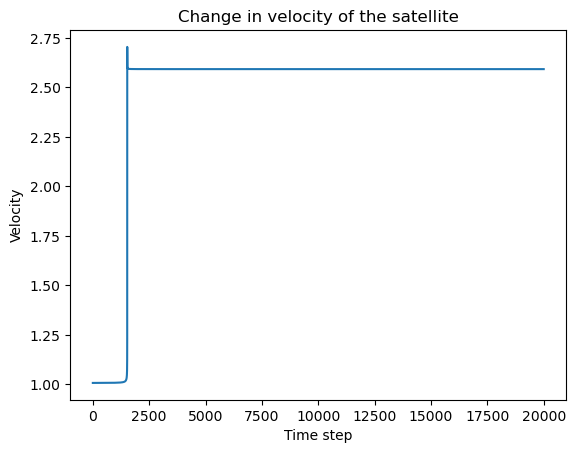

In [28]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

In [29]:
d = np.linalg.norm(r2-r3, axis=1)
closest_timestep = np.where(d == min(d))
print(closest_timestep)

print(min(d))

(array([1526]),)
0.000609534962930454


## Reducing Velocity
While this result is satisfactory, it would be greatly beneficial to instead consider the satellite moving at a slower velocity, as this means that it can move at a greater distance from the object and still be affected by the gravitational forces. Earlier, I noticed that there is somewhat of an issue involving the timestep. Without increasing the timestep, the planet jumps, making it difficult to place the satellite either in front or behind the orbit to reduce or increase its velocity. This issue could be rectified by increasing timestep, but this comes with a large increase in processing time. Moving the starting position of the satellite closer, reducing its velocity, and increasing the point of closest approach, I should have a system that is much easier to control but also allows for good slingshots and the same processing time.


Additionally, I will begin placing the satellite inside the orbit of the planet to prepare me for attempting to place it in a circular orbit later.

In [30]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((0.25, 1.25)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(0.05-0.25), 
                  1/1.57*(1-1.25)))

In [31]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



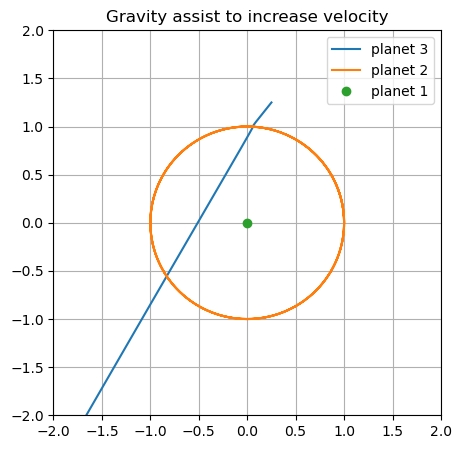

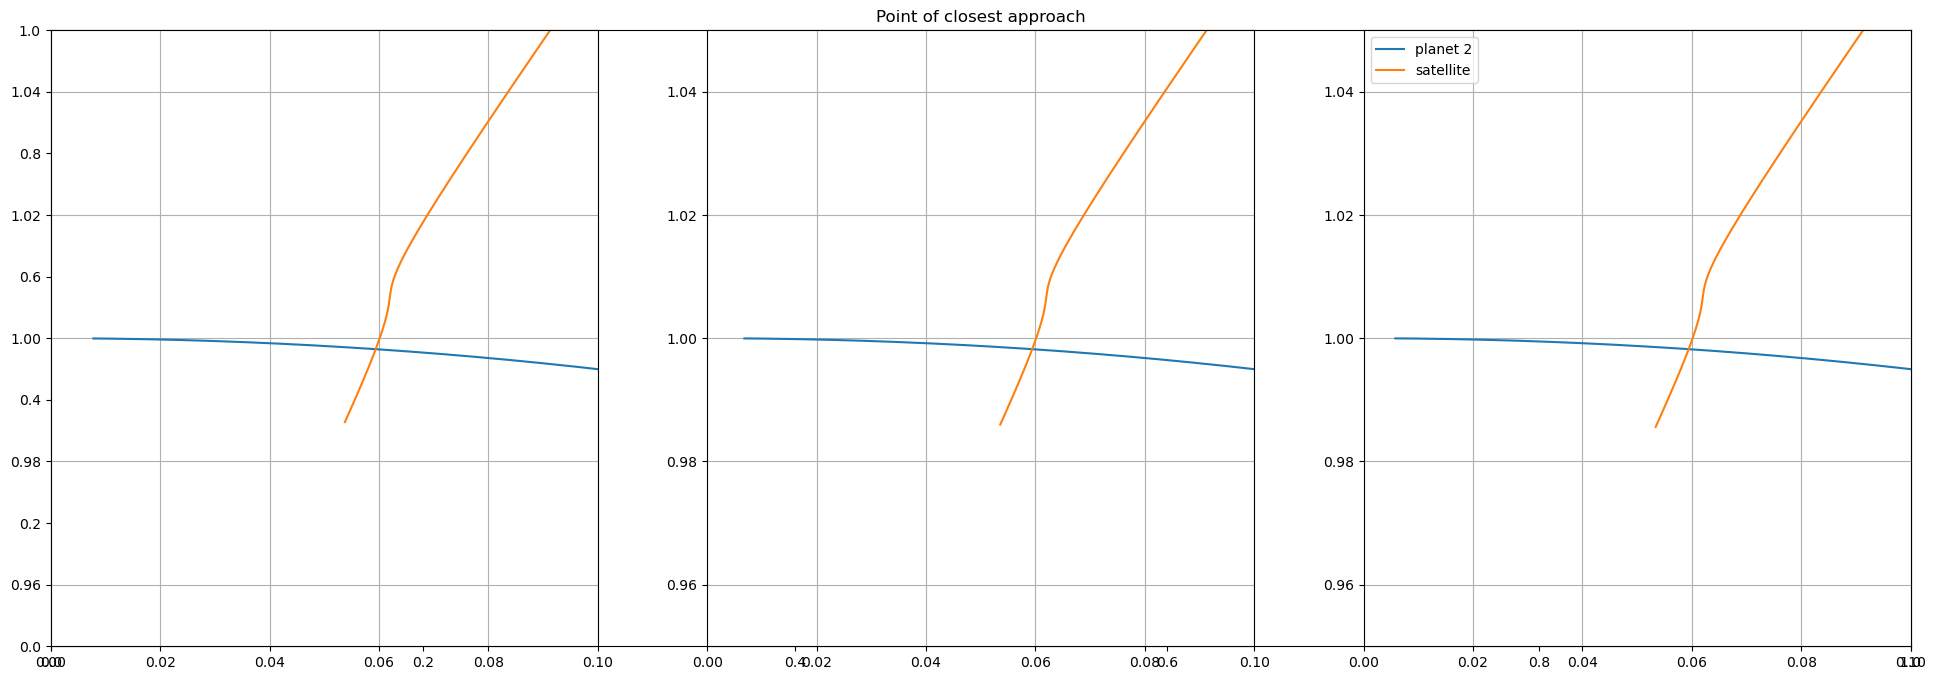

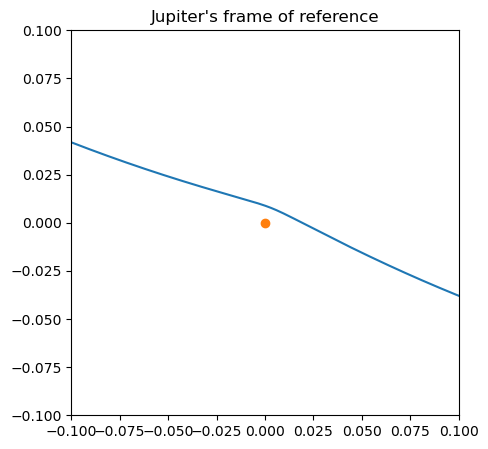

In [32]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist to increase velocity')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1563

fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

plt.figure(figsize=(5,5))
plt.title('Jupiter\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.plot(0,0,'o')


In [33]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 0.20392115405837097
Final velocity of satellite: 0.4392498008497535
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.008334288441073576


(array([1475]),)


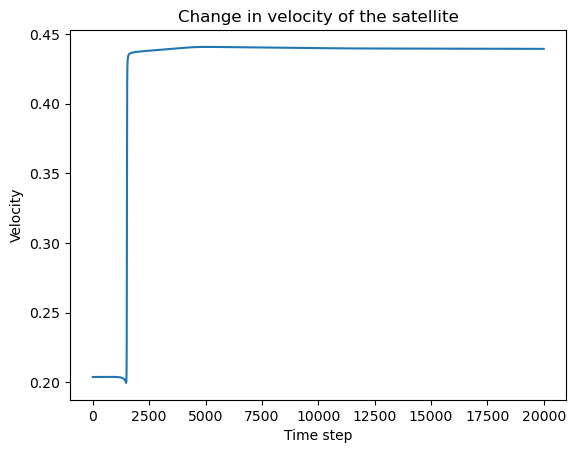

In [34]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

In [35]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((-0.25, 1.25)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((1/1.57*(-0.1+0.25), 
                  1/1.57*(1-1.25)))

In [36]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) #+ force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    collision_checker(r2[i], r3[i])

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) #+ force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



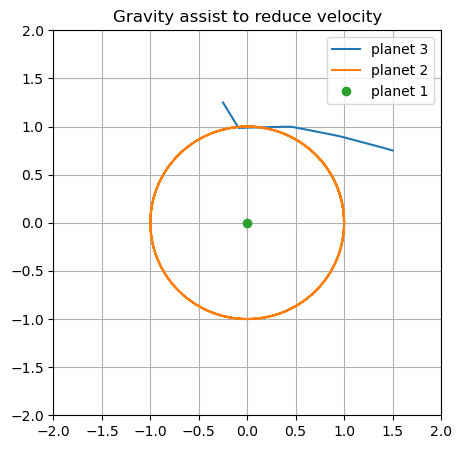

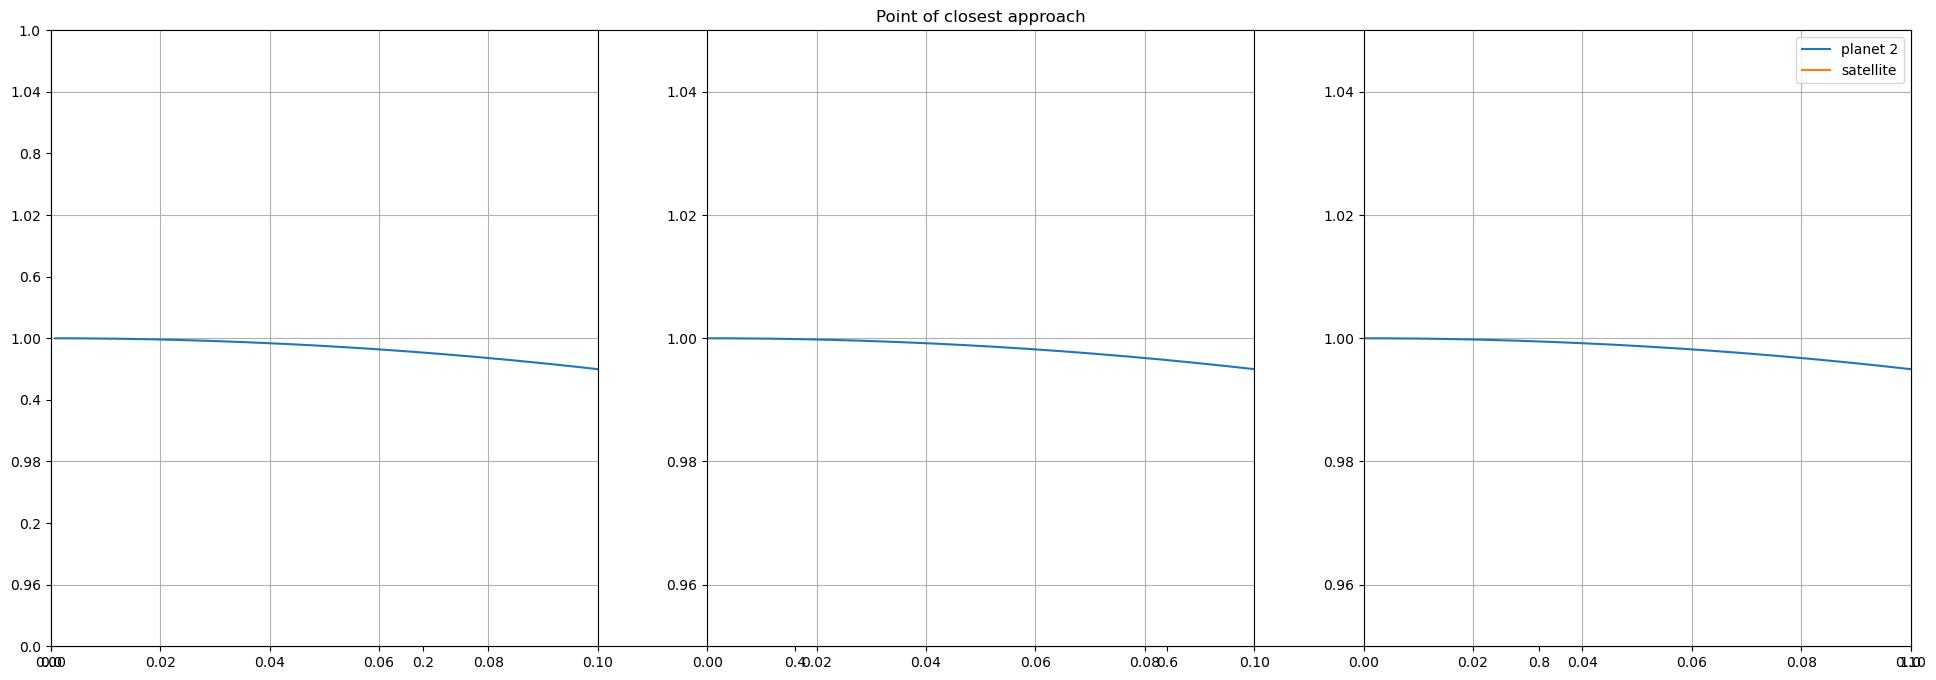

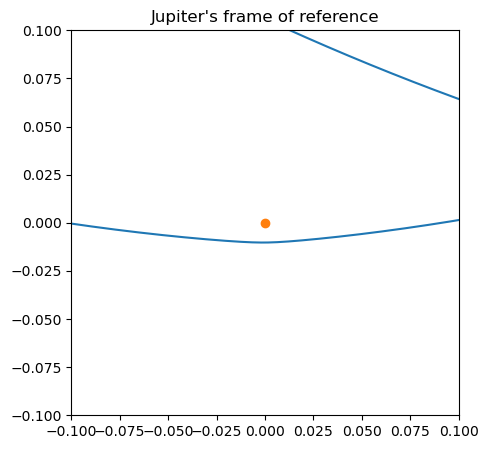

In [37]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist to reduce velocity')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1570

fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + 1*i,0], r2[:simend + 1*i,1], label='planet 2')
    ax.plot(r3[:simend + 1*i,0], r3[:simend + 1*i,1], label='satellite')
    ax.set_xlim(0,0.1)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

plt.figure(figsize=(5,5))
plt.title('Jupiter\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.plot(0,0,'o')


In [38]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 0.18569910493137898
Final velocity of satellite: 0.08193778122751921
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.01027001259176871


(array([19999]),)


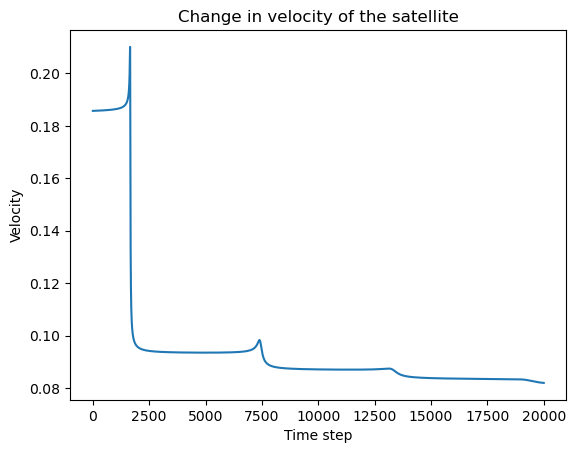

In [39]:
plt.plot(np.linalg.norm(v3,axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

As we can see during both cases, it is very much feasible to scale velocity to much greater extents by reducing the velocity of the satellite.

# Including circular orbit around the sun

Up to this point, circular orbits have not been including the influence of the sun on the satellite. As a result, these simulations are not yet good enough models for motion around the solar system. As is seen below, analytically determining the velocity required to reach the i.p. is no easy task, but experimenting with velocities allowed me to reach a velocity that brought the satellite very close to the intersection point. Taking the difference between these timesteps, we can lag the deployment of the satellite into the system so that it effectively intercepts the planet.

In [40]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

#lag = 1570 - 664 - this is the maximum lag before the satellite gets dangerously close to Jupiter
lag = 1570 - 654


# Initial conditions
r2[0] = np.array((1.0, 0))
r3[:lag+1] = np.array((0.5, 0)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[:lag+1] = np.array((0, np.sqrt(G*m1/0.25))) #+ 1/1.569 * (ip - r3[0])

In [41]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)

    collision_checker(r2[i], r3[i])

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 

for j in range(lag,Nsteps-1):
    # Finding forces on masses at this timestep
    f3 = force(r3[j], r2[j], m3, m2) + force(r3[j], r1[j], m3, m1)

    # Updating positions using velocity Verlet
    r3[j+1] = r3[j] + dt*v3[j] + (dt**2)*f3/(2*m3)

    collision_checker(r2[j], r3[j])

    # Finding forces at new timestep 
    f3new = force(r3[j+1], r2[j+1], m3, m2) + force(r3[j+1], r1[j+1], m3, m1)

    # Updating velocities using velocity Verlet
    v3[j+1] = v3[j] + dt*((f3+f3new) / (2*m3))



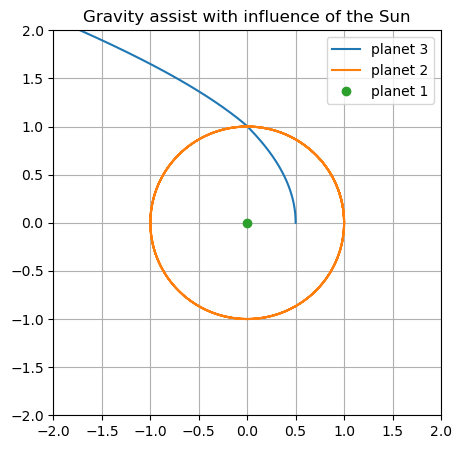

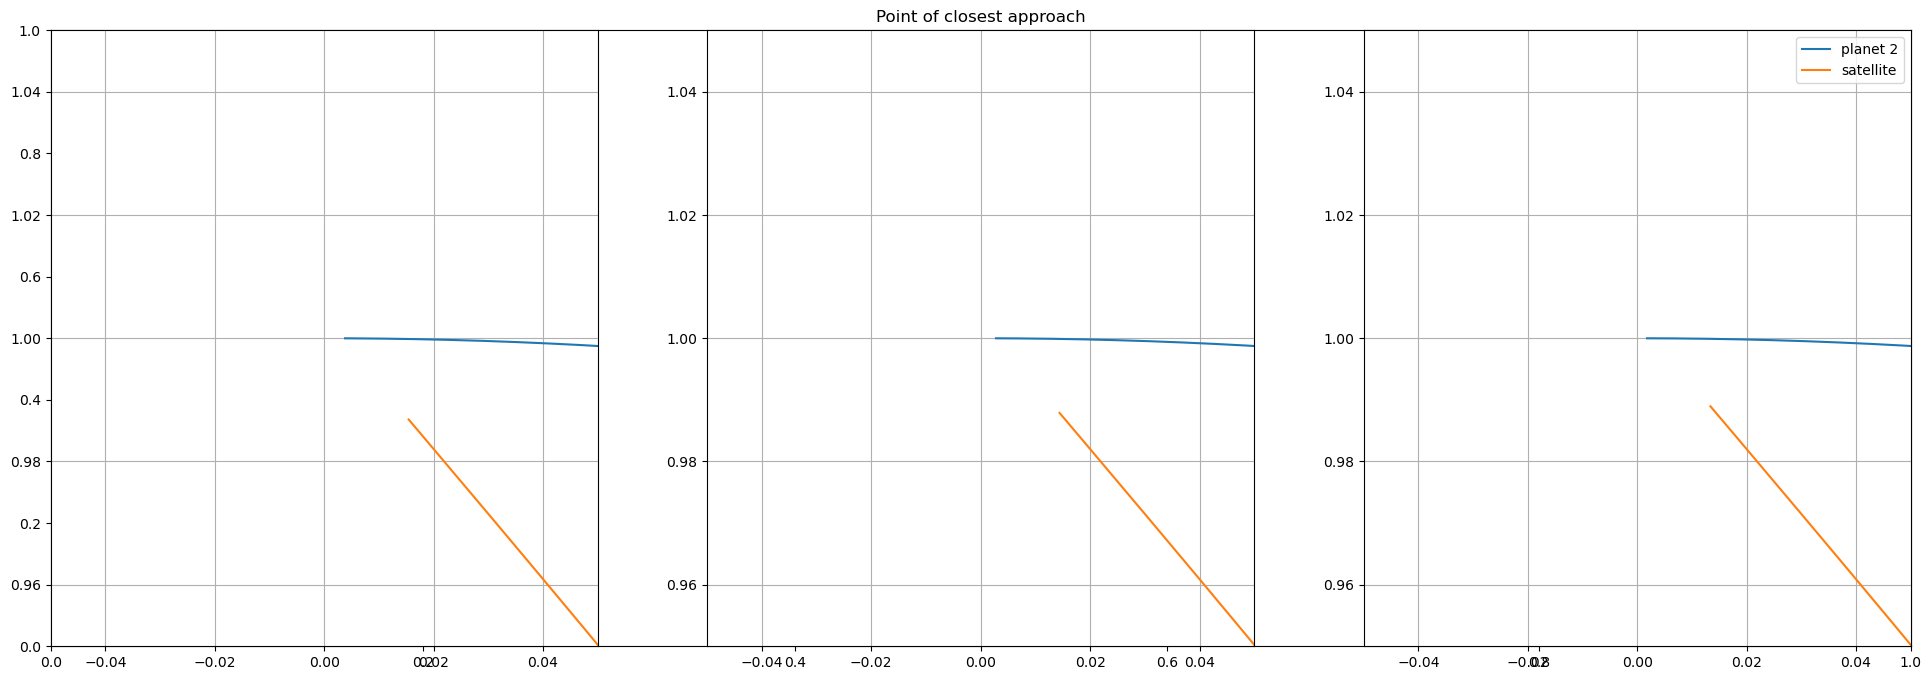

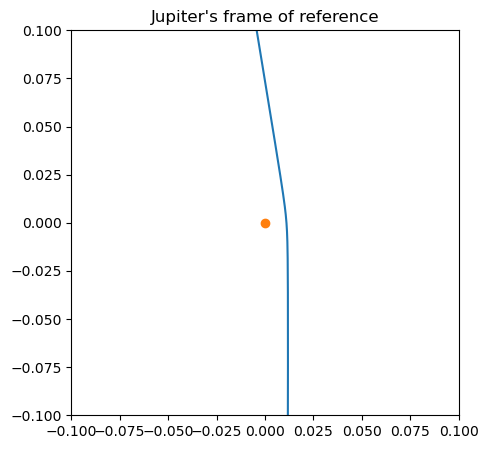

In [42]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist with influence of the Sun')
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.legend()

simend = 1567

n = 1
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + n*i,0], r2[:simend + n*i,1], label='planet 2')
    ax.plot(r3[:simend + n*i,0], r3[:simend + n*i,1], label='satellite')
    ax.set_xlim(-0.05,0.05)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

plt.figure(figsize=(5,5))
plt.title('Jupiter\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.plot(0,0,'o')


In [43]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 2.0
Final velocity of satellite: 0.6864416238540269
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.011061329643319073


(array([19999]),)


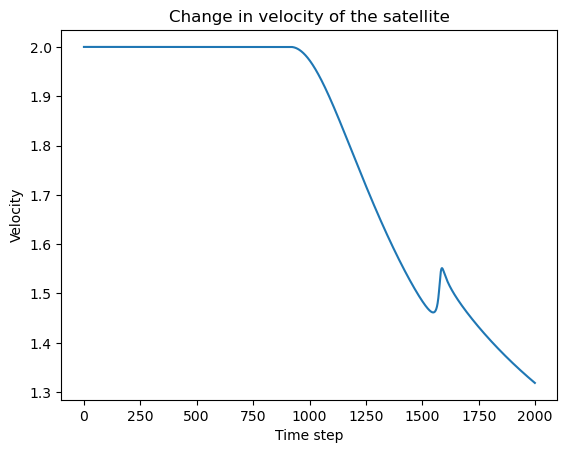

In [44]:
plt.plot(np.linalg.norm(v3[:2000],axis=1))
plt.title('Change in velocity of the satellite')
plt.xlabel('Time step')
plt.ylabel('Velocity')

print(np.where(np.linalg.norm(v3, axis=1) == min(np.linalg.norm(v3, axis=1))))

We can see here that we get a very satisfactory gravity assist from Jupiter by lagging the satellite s.t. it intersects it at the right point in time.

# Introducing a fourth body
Given my success with the previous part, I will attempt to model a fourth body which the satellite can subsequently slingshot off. The planet in question will be Saturn, with the orbital radius and mass approximately reflecting this.

In [286]:
# Simulating a two-body orbit

G = 1
m1 = 1
m2 = 1e-3
m3 = 1e-27
m4 = 1e-4
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.001

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
r4 = np.zeros((Nsteps, Ndim))

v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))
v4 = np.zeros((Nsteps, Ndim))

#lag = 1570 - 664 - this is the maximum lag before the satellite gets dangerously close to Jupiter
lag = 1570 - 659

lag2 = 2511 - 6898
lag2 = 2511 - 6892

# Initial conditions
r2[0] = np.array((1.0, 0))
r4[:lag2+1] = np.array((0, 2.0))
r3[:lag+1] = np.array((0.5, 0)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v4[:lag2+1] = np.array((2.35*np.sqrt(G*m1/2), 0))
v3[:lag+1] = np.array((0, np.sqrt(G*m1/0.25)))

In [287]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) 

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) 

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2)) 


for j in range(lag2, Nsteps-1):
    # Finding forces on masses at this timestep
    f4 = force(r4[j], r1[j], m4, m1) 

    # Updating positions using velocity Verlet
    r4[j+1] = r4[j] + dt*v4[j] + (dt**2)*f4/(2*m4)

    # Finding forces at new timestep 
    f4new = force(r4[j+1], r1[j+1], m2, m1) 

    # Updating velocities using velocity Verlet
    v4[j+1] = v4[j] + dt*((f4+f4new) / (2*m4)) 


for k in range(lag,Nsteps-1):
    # Finding forces on masses at this timestep
    f3 = force(r3[k], r2[k], m3, m2) + force(r3[k], r4[k], m3, m2) + force(r3[k], r1[k], m3, m1)

    # Updating positions using velocity Verlet
    r3[k+1] = r3[k] + dt*v3[k] + (dt**2)*f3/(2*m3)

    # Finding forces at new timestep 
    f3new = force(r3[k+1], r2[k+1], m3, m2) + force(r3[k+1], r4[k+1], m3, m2) + force(r3[k+1], r1[k+1], m3, m1)

    # Updating velocities using velocity Verlet
    v3[k+1] = v3[k] + dt*((f3+f3new) / (2*m3))


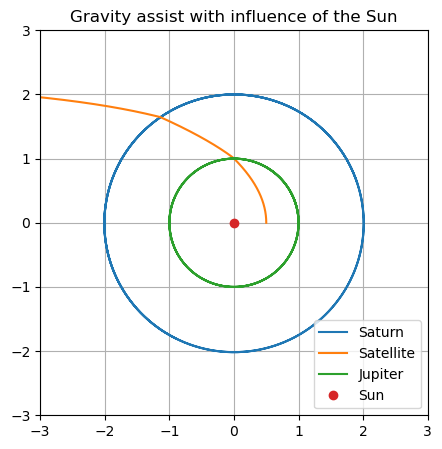

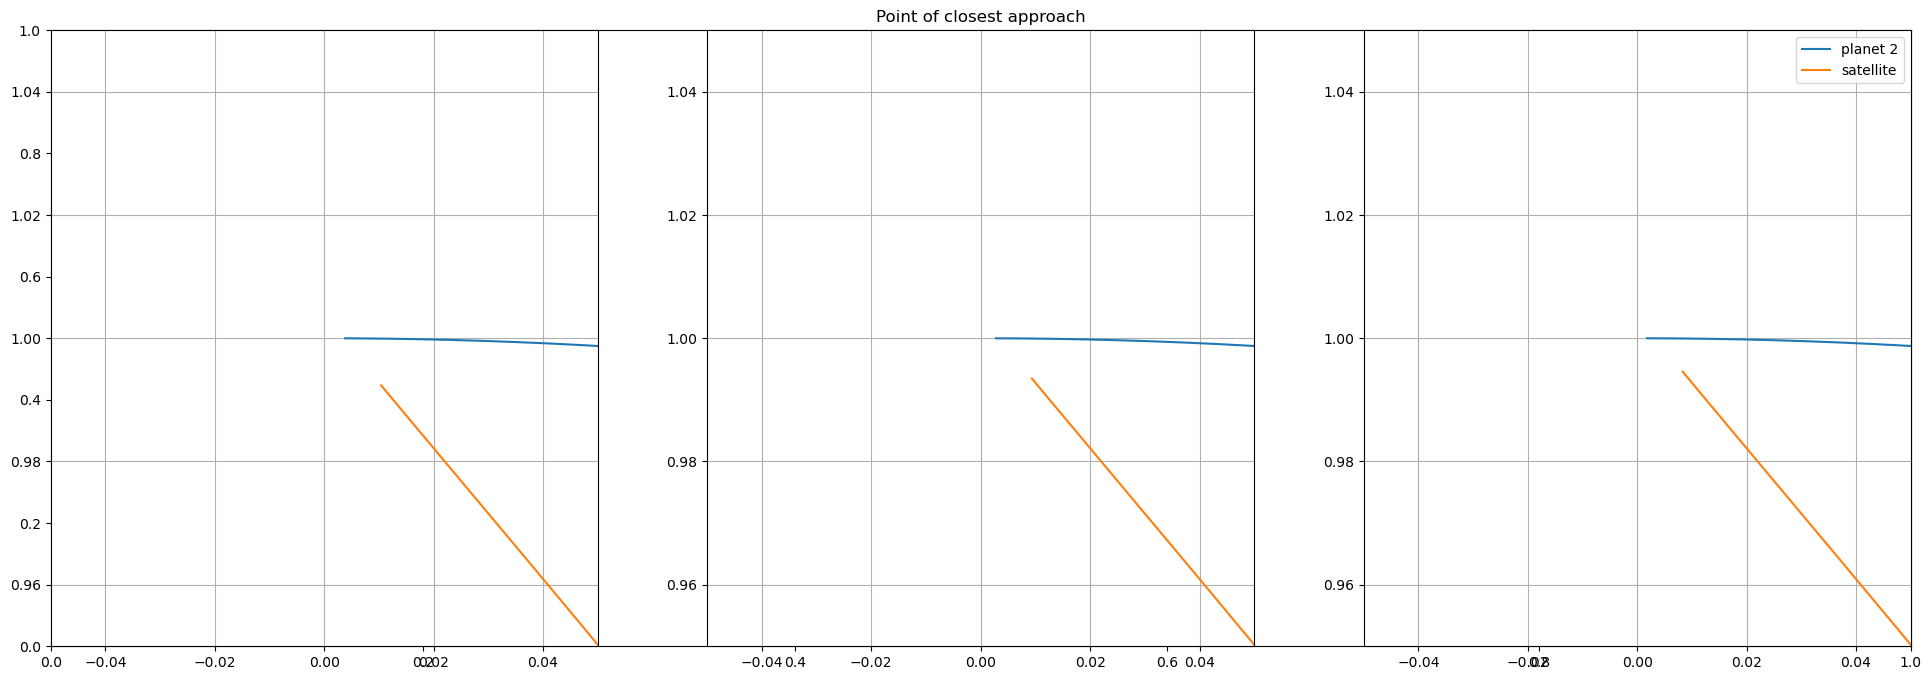

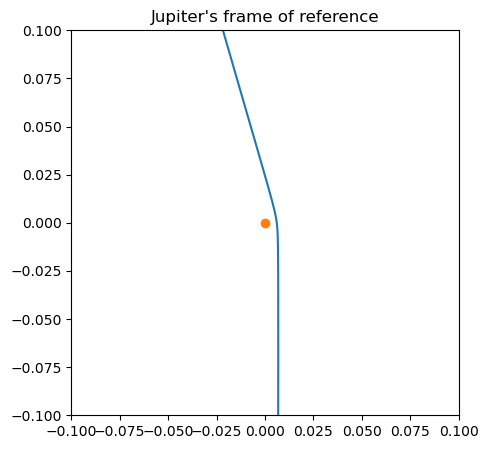

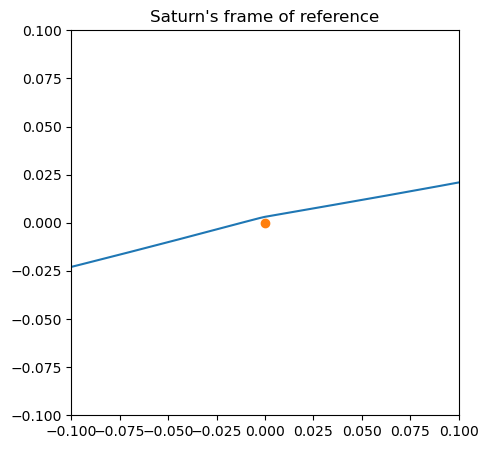

In [288]:
plt.figure(figsize=(5,5))
plt.title('Gravity assist with influence of the Sun')
plt.plot(r4[:,0], r4[:,1], label='Saturn')
plt.plot(r3[:,0], r3[:,1], label='Satellite')
plt.plot(r2[:,0], r2[:,1], label='Jupiter')
plt.plot(0, 0, 'o', label='Sun')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.legend()

simend = 1567

n = 1
fig = plt.figure(figsize=(24,8))
plt.title('Point of closest approach')
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    ax.plot(r2[:simend + n*i,0], r2[:simend + n*i,1], label='planet 2')
    ax.plot(r3[:simend + n*i,0], r3[:simend + n*i,1], label='satellite')
    ax.set_xlim(-0.05,0.05)
    ax.set_ylim(0.95, 1.05)
    ax.grid()
plt.legend()

plt.figure(figsize=(5,5))
plt.title('Jupiter\'s frame of reference')
plt.plot(r3[:,0]-r2[:,0], r3[:,1]-r2[:,1])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.plot(0,0,'o')

plt.figure(figsize=(5,5))
plt.title('Saturn\'s frame of reference')
plt.plot(r3[:,0]-r4[:,0], r3[:,1]-r4[:,1])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.plot(0,0,'o')


In [289]:
# Rough working
mag_r3 = np.linalg.norm(r3, axis=1)
print(np.where(abs(mag_r3 - 2) < 1e-3))

mag_r4 = np.linalg.norm(r4, axis=1)
print(np.where(abs(r4 - r3[2511]) < 1e-3))




(array([2509, 2510]),)
(array([  167,   168,  2515,  2515,  2516,  3972,  3973,  7792, 10139,
       10139, 10140, 10140, 11597, 11598, 15416, 15417, 17764, 17764,
       17765, 19221, 19222]), array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]))


In [290]:
print(f'Initial velocity of satellite: {np.linalg.norm(v3[0])}')
print(f'Final velocity of satellite: {np.linalg.norm(v3[-1])}')

print(f'Initial velocity of planet 2: {np.linalg.norm(v2[0])}')
print(f'Final velocity of planet 2: {np.linalg.norm(v2[-1])}')

e_0 = 0.5 * (m2*np.linalg.norm(v2[0])**2 + m3*np.linalg.norm(v3[0])**2)
e_f = 0.5 * (m2*np.linalg.norm(v2[-1])**2 + m3*np.linalg.norm(v3[-1])**2)

print(f'Initial energy of both planets: {e_0}')
print(f'Final energy of both planets: {e_f}')
print(f'Difference in energies: {e_0 - e_f}')

d = np.linalg.norm(r2-r3, axis=1)
print(f'Point of closest approach: {min(d)}')

Initial velocity of satellite: 2.0
Final velocity of satellite: 0.6383267996673603
Initial velocity of planet 2: 1.0
Final velocity of planet 2: 0.9999998522491199
Initial energy of both planets: 0.0005
Final energy of both planets: 0.0004999998522491309
Difference in energies: 1.477508691566029e-10
Point of closest approach: 0.006060123497546417
